<a href="https://colab.research.google.com/github/kavya6301/Object-detection_with-faster-RCNN/blob/main/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_gpu==1.15

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
import shutil
from shutil import copyfile
import sys
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
import h5py


In [ ]:
# import wget
# url = 'https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv'
# filename = wget.download(url)
# url = 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv'
# filename = wget.download(url)
# url = 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv'
# filename = wget.download(url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
images_boxable_file = '/content/drive/MyDrive/My project/train-images-boxable-with-rotation.csv'
annotations_bbox_file = '/content/drive/MyDrive/My project/train-annotations-bbox.csv'
class_descriptions_file = '/content/drive/MyDrive/My project/class-descriptions-boxable.csv'

In [5]:
images_boxable = pd.read_csv(images_boxable_file)
images_boxable.head()

ImageID  ... Rotation
0  4fa8054781a4c382  ...      0.0
1  b37f763ae67d0888  ...      0.0
2  7e8584b0f487cb9e  ...      0.0
3  86638230febe21c4  ...      NaN
4  249086e72671397d  ...      0.0

[5 rows x 12 columns]

In [6]:
images_boxable.count()

ImageID               1743042
Subset                1743042
OriginalURL           1743042
OriginalLandingURL    1743042
License               1743042
AuthorProfileURL      1743042
Author                1743042
Title                 1743042
OriginalSize          1743042
OriginalMD5           1743042
Thumbnail300KURL      1705689
Rotation              1495772
dtype: int64

In [7]:
annotations_bbox = pd.read_csv(annotations_bbox_file)
annotations_bbox.head()

ImageID  Source  LabelName  ...  IsGroupOf  IsDepiction  IsInside
0  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
1  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
2  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
3  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
4  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0

[5 rows x 13 columns]

In [8]:
class_descriptions = pd.read_csv(class_descriptions_file, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [9]:
len(class_descriptions[1].unique())

601

In [10]:
# Code for plotting bounding box
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Image: (3264, 4928, 3)
Coordinates: (736, 462), (4838, 3260)


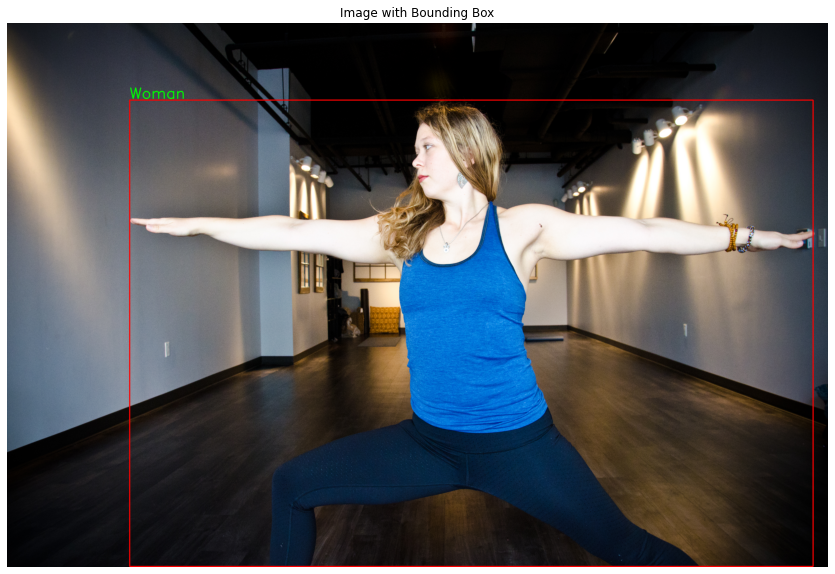

Image: (1067, 1600, 3)
Coordinates: (802, 112), (1599, 416)


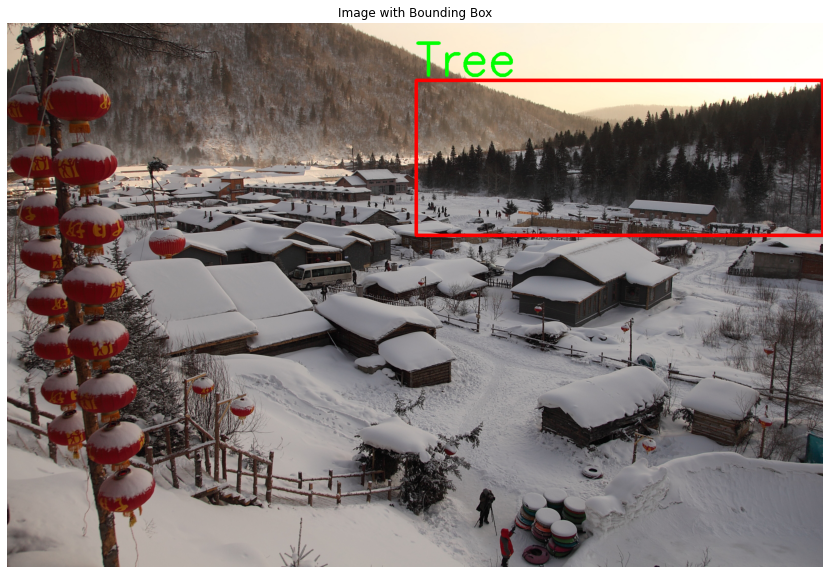

Image: (3456, 4608, 3)
Coordinates: (17, 1411), (4605, 3453)


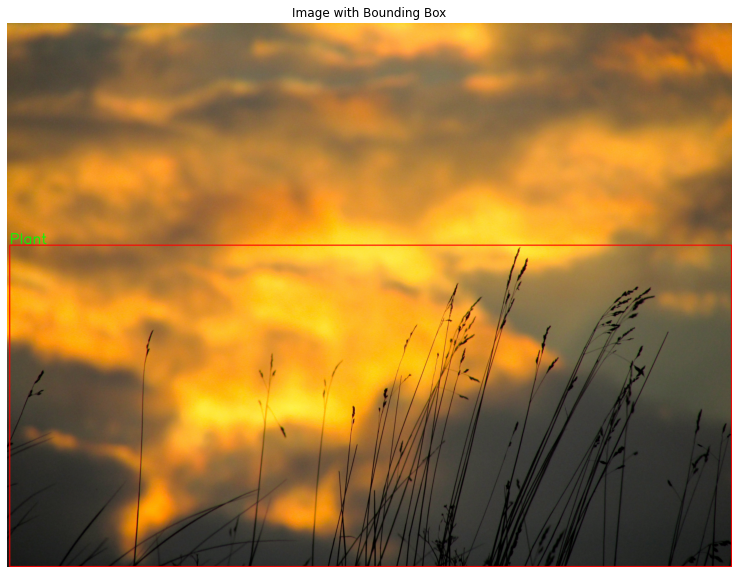

Image: (3264, 4896, 3)
Coordinates: (0, 0), (4892, 3260)


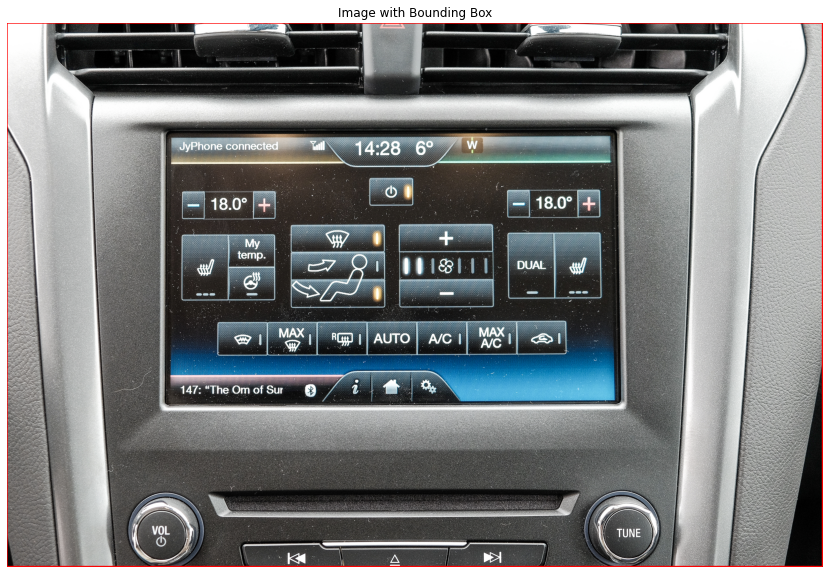

Image: (1826, 2979, 3)
Coordinates: (299, 450), (2152, 1248)


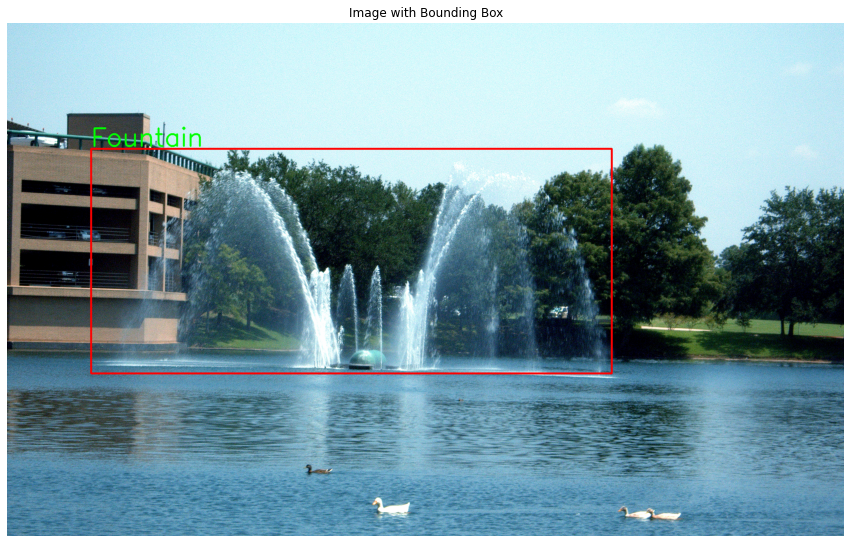

In [ ]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

In [11]:
class_descriptions[1].count()

601

In [12]:
class_descriptions[1].unique()

array(['Tortoise', 'Container', 'Magpie', 'Sea turtle', 'Football',
       'Ambulance', 'Ladder', 'Toothbrush', 'Syringe', 'Sink', 'Toy',
       'Organ (Musical Instrument)', 'Cassette deck', 'Apple',
       'Human eye', 'Cosmetics', 'Paddle', 'Snowman', 'Beer',
       'Chopsticks', 'Human beard', 'Bird', 'Parking meter',
       'Traffic light', 'Croissant', 'Cucumber', 'Radish', 'Towel',
       'Doll', 'Skull', 'Washing machine', 'Glove', 'Tick', 'Belt',
       'Sunglasses', 'Banjo', 'Cart', 'Ball', 'Backpack', 'Bicycle',
       'Home appliance', 'Centipede', 'Boat', 'Surfboard', 'Boot',
       'Headphones', 'Hot dog', 'Shorts', 'Fast food', 'Bus', 'Boy',
       'Screwdriver', 'Bicycle wheel', 'Barge', 'Laptop', 'Miniskirt',
       'Drill (Tool)', 'Dress', 'Bear', 'Waffle', 'Pancake', 'Brown bear',
       'Woodpecker', 'Blue jay', 'Pretzel', 'Bagel', 'Tower', 'Teapot',
       'Person', 'Bow and arrow', 'Swimwear', 'Beehive', 'Brassiere',
       'Bee', 'Bat (Animal)', 'Starfish', 'Popc

In [13]:
classes=['Girl','Plant','Man']

In [14]:
girl_pd = class_descriptions[class_descriptions[1]=='Girl']
plant_pd = class_descriptions[class_descriptions[1]=='Plant']
man_pd = class_descriptions[class_descriptions[1]=='Man']

In [15]:
label_name_girl = girl_pd[0].values[0]
label_name_plant = plant_pd[0].values[0]
label_name_man = man_pd[0].values[0]

In [16]:
girl_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_girl]
plant_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_plant]
man_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_man]

In [17]:
# class_pd=class_descriptions
girl_img_id = girl_bbox['ImageID']
plant_img_id = plant_bbox['ImageID']
man_img_id = man_bbox['ImageID']

In [18]:
# working on 10 images
n = 10
subgirl_img_id = random.sample(list(girl_img_id), n)
subplant_img_id = random.sample(list(plant_img_id), n)
subman_img_id = random.sample(list(man_img_id), n)

In [19]:
subgirl_pd = images_boxable.loc[images_boxable['ImageID'].isin(subgirl_img_id)]
subplant_pd = images_boxable.loc[images_boxable['ImageID'].isin(subplant_img_id)]
subman_pd = images_boxable.loc[images_boxable['ImageID'].isin(subman_img_id)]

In [20]:
subgirl_dict = subgirl_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subplant_dict = subplant_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subman_dict = subman_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [ ]:
subgirl_pd.head()

ImageID  ... Rotation
106915   0389d703f30b2e3a  ...      0.0
299827   7c4b52257090e384  ...      0.0
483393   819cdd5beb9d411a  ...      0.0
879848   334d43980a30691a  ...      NaN
1026899  5ddec022cbd992cb  ...      0.0

[5 rows x 12 columns]

In [ ]:
mappings = [subgirl_dict, subplant_dict, subman_dict]

In [ ]:
for idx, obj_type in enumerate(classes):
  n_issues = 0
  dir='/content/drive/MyDrive/My project/'+obj_type
  # create the directory
  if not os.path.exists(dir):
    os.mkdir(dir)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(dir, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 1
Images Issues: 1
Images Issues: 2


In [21]:
# save images to train and test directory, so create 2 folders
train_path = '/content/drive/MyDrive/My project/train/'
test_path = '/content/drive/MyDrive/My project/test/'

In [ ]:
for i in range(len(classes)):
    all_imgs = os.listdir('/content/drive/MyDrive/My project/'+str(classes[i]))
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8) # 80% data for training and 20% for testing

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    
    for j in range(len(train_imgs)):
        original_path = os.path.join('/content/drive/MyDrive/My project/'+str(classes[i]), train_imgs[j])
        # new_path = os.path.join(train_path, train_imgs[j])
        shutil.copy(original_path,train_path)
        # copyfile(original_path, new_path)
    

    for j in range(len(test_imgs)):
        original_path = os.path.join('/content/drive/MyDrive/My project/'+str(classes[i]), test_imgs[j])
        # new_path = os.path.join(test_path, test_imgs[j])
        shutil.copy(original_path, test_path)

In [ ]:
train_img_count = os.listdir('/content/drive/MyDrive/My project/train')
print("Number of images in train found: ", len(train_img_count))

Number of images in train found:  24


In [ ]:
test_img_count = os.listdir('/content/drive/MyDrive/My project/test')
print("Number of images in test found: ", len(test_img_count))

Number of images in test found:  2


In [ ]:
label_names = [label_name_girl, label_name_plant, label_name_man]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [ ]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  3cf2fed04943c088.jpg  0.018750  0.111875  0.393333  0.614167      Girl
1  3cf2fed04943c088.jpg  0.138125  0.212500  0.349167  0.531667      Girl
2  3cf2fed04943c088.jpg  0.163750  0.210000  0.312500  0.412500      Girl
3  3cf2fed04943c088.jpg  0.293750  0.326250  0.291667  0.367500      Girl
4  3cf2fed04943c088.jpg  0.365000  0.393750  0.267500  0.309167      Girl

In [ ]:
train_df.shape

(262, 6)

Image: (3240, 4320, 3)
Coordinates: (3574, 1385), (4314, 3240)
Coordinates: (3712, 1282), (4287, 2621)
Coordinates: (3564, 1333), (4314, 3240)
Coordinates: (3863, 512), (4320, 1382)
Coordinates: (1074, 729), (2778, 2027)
Coordinates: (0, 1431), (413, 2286)
Coordinates: (113, 1352), (496, 1984)
Coordinates: (213, 1152), (261, 1336)
Coordinates: (286, 1152), (423, 1341)
Coordinates: (334, 1347), (753, 2022)
Coordinates: (459, 1120), (664, 1560)
Coordinates: (642, 1198), (909, 1711)
Coordinates: (737, 1090), (1004, 1598)
Coordinates: (866, 834), (1836, 1622)
Coordinates: (1863, 1854), (3561, 3218)
Coordinates: (2259, 378), (3944, 1107)
Coordinates: (2783, 1055), (3510, 2421)
Coordinates: (3426, 747), (3801, 1914)
Coordinates: (3801, 658), (4317, 1468)
Coordinates: (70, 1255), (283, 1401)
Coordinates: (315, 1209), (472, 1350)
Coordinates: (3464, 575), (3663, 769)
Coordinates: (4044, 440), (4284, 707)
Coordinates: (0, 180), (4166, 2278)
Coordinates: (1860, 1676), (3585, 3237)
Coordinates: (

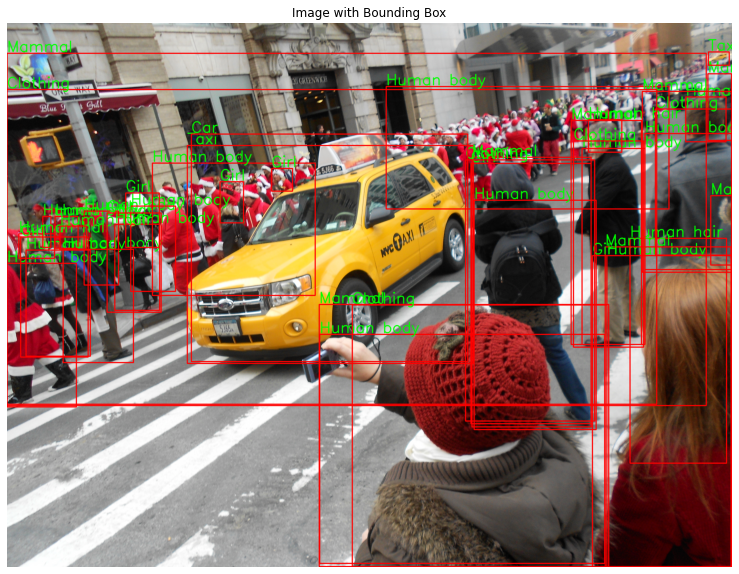

In [ ]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique() # plotting the bounding box
for img_id in train_img_ids:
  plot_bbox(img_id)

In [ ]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [ ]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [ ]:
#Write train.csv to annotation.txt

train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('/content/drive/MyDrive/My project/train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      train_file_path = '/content/drive/MyDrive/My project/train'
      fileName = os.path.join(train_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [ ]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('/content/drive/MyDrive/My project/test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      test_file_path = '/content/drive/MyDrive/My project/test'
      fileName = os.path.join(test_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [ ]:
# read the csv file using read_csv function of pandas
train = pd.read_csv('/content/train.csv')
train.head()

Unnamed: 0              FileName      XMin  ...      YMin      YMax  ClassName
0           0  3cf2fed04943c088.jpg  0.018750  ...  0.393333  0.614167       Girl
1           1  3cf2fed04943c088.jpg  0.138125  ...  0.349167  0.531667       Girl
2           2  3cf2fed04943c088.jpg  0.163750  ...  0.312500  0.412500       Girl
3           3  3cf2fed04943c088.jpg  0.293750  ...  0.291667  0.367500       Girl
4           4  3cf2fed04943c088.jpg  0.365000  ...  0.267500  0.309167       Girl

[5 rows x 7 columns]

In [ ]:
data = pd.DataFrame()
data['format'] = train['FileName']

# as the images are in train_images folder, add train_images before the image name
for i in range(data.shape[0]):
    data['format'][i] = 'train_images/' + data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train['XMin'][i]) + ',' + str(train['YMin'][i]) + ',' + str(train['XMax'][i]) + ',' + str(train['YMax'][i]) + ',' + train['ClassName'][i]

data.to_csv('annotate.txt', header=None, index=None, sep=' ')

In [22]:
def partial_vgg(input_tensor=None):


    input_shape = (None, None, 3)

    img_input = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    print(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    print(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    print(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    print(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # We are not using fully connected layers (3 fc layers) as we need feature maps as output from this network.

    return x
#RPN layer

In [23]:
def rpn_layer(base_layers, num_anchors):
 
    #cnn_used for creating feature maps: vgg, num_anchors: 9
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(base_layers)
    
    #classification layer: num_anchors (9) channels for 0, 1 sigmoid activation output
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid')(x)
    
    #regression layer: num_anchors*4 (36) channels for computing the regression of bboxes
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear')(x)

    return [x_class, x_regr, base_layers] #classification of object(0 or 1),compute bounding boxes, base layers vgg

In [24]:
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

Using TensorFlow backend.


In [25]:
class RoiPoolingConv(Layer):

    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels) : (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
#Classifier layer

def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):

    # base_layers: vgg
    #input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    #num_rois: number of rois to be processed in one time (4 in here)
    
    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = Flatten(name='flatten')(out_roi_pool) #expanded into a vector with 25,088 (7×7×512) channels.
    out = Dense(4096, activation='relu', name='fc1')(out)
    out = Dropout(0.5)(out)
    out = Dense(4096, activation='relu', name='fc2')(out)
    out = Dropout(0.5)(out)

    # two output layer- classifier and regressor
    # for classify the class name of the object
    out_class = Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes)(out)
    
    #for bboxes coordinates regression
    out_regr = Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes)(out)

    return [out_class, out_regr]

In [31]:
! git clone https://github.com/kavya6301/keras-frcnn.git

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 638, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 638 (delta 0), reused 0 (delta 0), pack-reused 637
Receiving objects: 100% (638/638), 188.41 KiB | 4.83 MiB/s, done.
Resolving deltas: 100% (435/435), done.


In [ ]:
% cd keras-frcnn

In [ ]:
! python train_frcnn.py -o simple -p annotate.txt